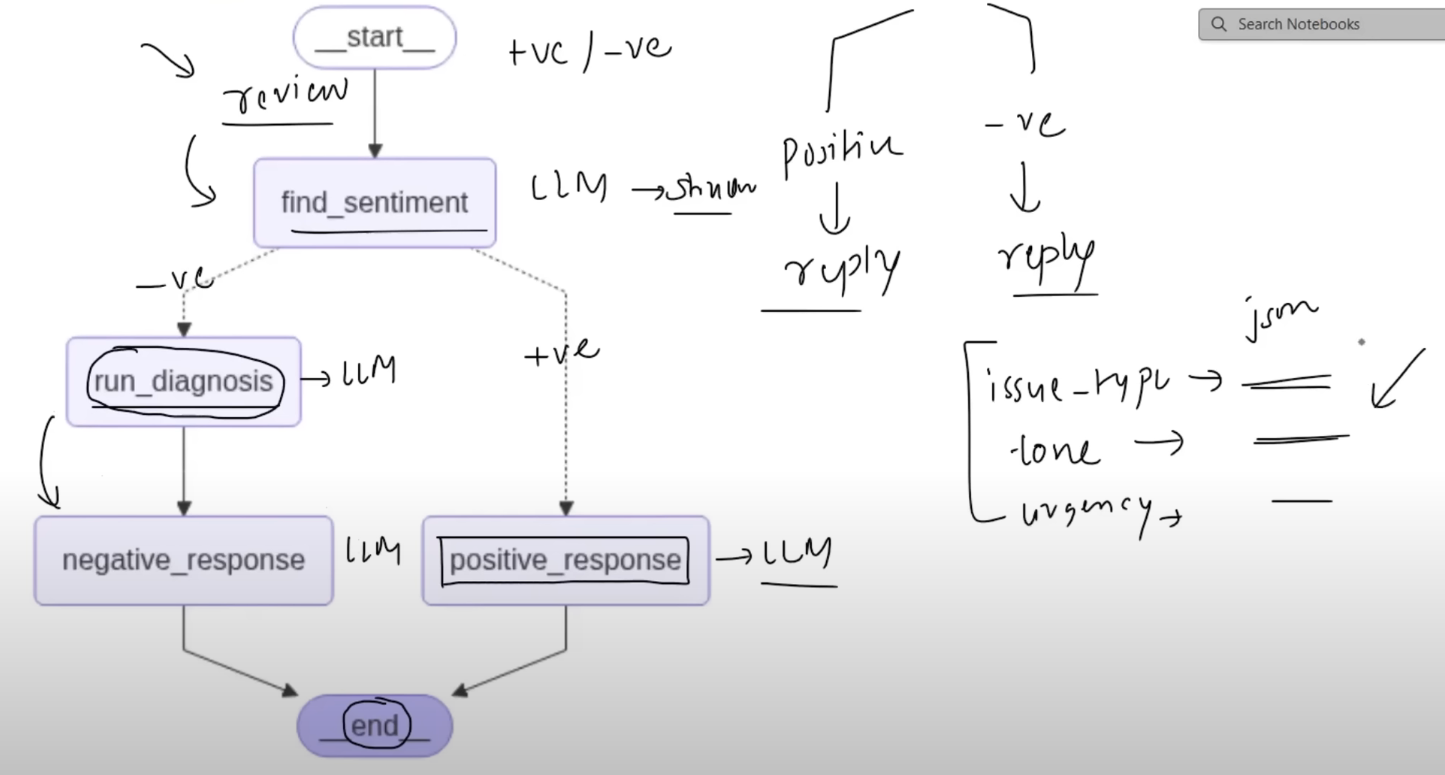


- If review is negative then diagnose the Review and understand the issue, tone and urgency from the review.

- If positive review then just give a positive reply


In [1]:
from langgraph.graph import StateGraph, START, END
from langchain_groq import ChatGroq
from typing import TypedDict, Literal
from pydantic import BaseModel, Field
from dotenv import load_dotenv

In [2]:
load_dotenv()

True

In [3]:
model = ChatGroq(model="llama-3.1-8b-instant")

In [5]:
class SentimentSchema(BaseModel):
    sentiment: Literal["positive", "negative"] = Field(
        description="Sentiment of the Review"
    )

In [ ]:
model.invoke("What is the sentiment of the review - The product is very bad")

AIMessage(content='The sentiment of the review is extremely negative. The reviewer explicitly states that the product is "very bad", which indicates a strong disapproval and dissatisfaction with the product.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 48, 'total_tokens': 82, 'completion_time': 0.030927911, 'prompt_time': 0.009063792, 'queue_time': 0.051377068, 'total_time': 0.039991703}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_46fc01befd', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--4fe74a4f-7474-453c-b117-628131a4b099-0', usage_metadata={'input_tokens': 48, 'output_tokens': 34, 'total_tokens': 82})

In [7]:
model_with_struct = model.with_structured_output(SentimentSchema)

In [ ]:
model_with_struct.invoke(
    "What is the sentiment of the review - The product is very bad"
)

SentimentSchema(sentiment='negative')

In [16]:
class SentimentState(TypedDict):
    review: str
    sentiment: Literal["positive", "negative"]

    # diagnosis for conditional chain

    diagnosis: dict
    response: str

In [28]:
graph = StateGraph(SentimentState)

In [22]:
# This function will return sentiment positve or negative
def get_sentiment(state: SentimentState) -> SentimentState:
    prompt = f"For the following review find the sentiment.\n {state['review']}"

    sentiment = model_with_struct.invoke(prompt)

    return {"sentiment": sentiment}


# This function is checking condition and return the node name
def check_sentiment(
    state: SentimentState,
) -> Literal["postive_response", "run_diagnosis"]:
    if state["sentiment"] == "positive":
        return "postive_response"
    else:
        return "run_diagnosis"


# This Function is for postive reply
def postive_response(state: SentimentState) -> SentimentState:
    prompt = f"Write a warm thank you message in response to this review. \n {state['review']}"

    # Because we only need normal resposne not a sentiment calculation for it
    response = model.invoke(prompt).content

    return {"response": response}


> Because our Diagnosis is also having a structure output of issue, tone,and urgency


In [23]:
class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(
        description="The category of issue mentioned in the review"
    )
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(
        description="The emotional tone expressed by the user"
    )
    urgency: Literal["low", "medium", "high"] = Field(
        description="How urgent or critical the issue appears to be"
    )

In [24]:
model_with_diagnosis_struc = model.with_structured_output(DiagnosisSchema)

In [25]:
# This function is to run diagnosis if the sentiment of response is negative


"""
For this we need to fetch three things from diagnonsis:
- issue type
- tone
- urgency
Thus based on review we need to get structure output based on this review
"""


def run_diagnosis(state: SentimentState) -> SentimentState:
    prompt = f"Diagnose this negative review:\n\n{state['review']}\nReturn issue_type, tone, and urgency."

    response = model_with_diagnosis_struc.invoke(prompt)
    # Since our response is json object we will convet it to dictionary(Because it is a pydantic object we can easily do that)

    return {"diagnosis": response.model_dump()}


In [26]:
# This function gives a negative response


def negative_response(state: SentimentState) -> SentimentState:
    diagnosis = state["diagnosis"]

    prompt = f"You are a support assistant. The user had a {diagnosis['issue_type']} issue, sounded {diagnosis['tone']}, and marked urgency as {diagnosis['urgency']}.Write an empathetic, helpful resolution message."

    response = model.invoke(prompt).content

    return {"response": response}


In [35]:
graph = StateGraph(SentimentState)

In [36]:
graph.add_node("find_sentiment", get_sentiment)
graph.add_node("postive_response", postive_response)
graph.add_node("run_diagnosis", run_diagnosis)
graph.add_node("negative_response", negative_response)

In [37]:
# Now edges
graph.add_edge(START, "find_sentiment")
graph.add_conditional_edges("find_sentiment", check_sentiment)
graph.add_edge("postive_response", END)
graph.add_edge("run_diagnosis", "negative_response")
graph.add_edge("negative_response", END)

workflow = graph.compile()

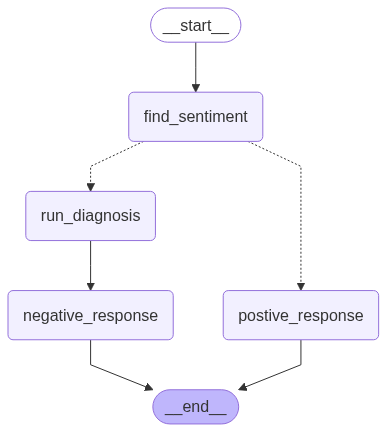

In [38]:
workflow

**Testing**


In [39]:
intial_state = {
    "review": "I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality."
}
workflow.invoke(intial_state)

{'review': 'I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality.',
 'sentiment': SentimentSchema(sentiment='negative'),
 'diagnosis': {'issue_type': 'Bug', 'tone': 'frustrated', 'urgency': 'high'},
 'response': "**Subject: Re: Urgent - Bug Issue**\n\nDear [User],\n\nI'm so sorry to hear that you're experiencing a frustrating bug issue. I can imagine how frustrating it must be to encounter problems while using our service. I'm here to help and I've taken immediate action to assist you.\n\nI've reviewed your case and I'm working on resolving the issue as quickly as possible. In the meantime, I'd like to offer some temporary workarounds to help you continue using our service:\n\n1. [Temporary solution or workaround]\n2. [Alternative solution]\n\nTo provide you with a more permanent fix, I've escalated your case to